In [29]:
from json import load
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Get the fitness of a given route
def eval_indvidual_fitness(individual, instance, unit_cost):
    vehicles = getNumVehiclesRequired(individual, instance)
    route_cost = getRouteCost(individual, instance, unit_cost)

    return (vehicles, route_cost)

# Calculate the number of vehicles required, given a route
def getNumVehiclesRequired(individual, instance):
    updated_route = routeToSubroute(individual, instance)
    num_of_vehicles = len(updated_route)
    return num_of_vehicles


# Given a route, give its total cost
def getRouteCost(individual, instance, unit_cost=1):  
    total_cost = 0
    updated_route = routeToSubroute(individual, instance)

    for sub_route in updated_route:
        # Initializing the subroute distance to 0
        sub_route_distance = 0
        # Initializing customer id for depot as 0
        last_customer_id = 0

        for customer_id in sub_route:
            # Distance from the last customer id to next one in the given subroute
            distance = instance["distance_matrix"][last_customer_id][customer_id]
            sub_route_distance += distance
            # Update last_customer_id to the new one
            last_customer_id = customer_id
        
        # After adding distances in subroute, adding the route cost from last customer to depot
        # that is 0
        sub_route_distance = sub_route_distance + instance["distance_matrix"][last_customer_id][0]

        # Cost for this particular sub route
        sub_route_transport_cost = unit_cost*sub_route_distance

        # Adding this to total cost
        total_cost = total_cost + sub_route_transport_cost
    
    return total_cost

# Take a route of given length, divide it into subroute where each subroute is assigned to vehicle
def routeToSubroute(individual, instance):
    route = []
    sub_route = []
    vehicle_load = 0
    # last_customer_id = 0
    vehicle_capacity = instance['vehicle_capacity']
    
    for customer_id in individual:
        
        demand = instance[f"customer_{customer_id}"]["demand"]
        updated_vehicle_load = vehicle_load + demand

        if(updated_vehicle_load <= vehicle_capacity):
            sub_route.append(customer_id)
            vehicle_load = updated_vehicle_load
        else:
            route.append(sub_route)
            sub_route = [customer_id]
            vehicle_load = demand
        
        # last_customer_id = customer_id

    if sub_route != []:
        route.append(sub_route)

    # Returning the final route with each list inside for a vehicle
    return route


In [31]:
def cxOrderedVrp(input_ind1, input_ind2):
    # Modifying this to suit our needs
    #  If the sequence does not contain 0, this throws error
    #  So we will modify inputs here itself and then 
    #       modify the outputs too

    ind1 = [x-1 for x in input_ind1]
    ind2 = [x-1 for x in input_ind2]
    size = min(len(ind1), len(ind2))
    a, b = random.sample(range(size), 2)
    if a > b:
        a, b = b, a

    holes1, holes2 = [True] * size, [True] * size
    for i in range(size):
        if i < a or i > b:
            holes1[ind2[i]] = False
            holes2[ind1[i]] = False

    # We must keep the original values somewhere before scrambling everything
    temp1, temp2 = ind1, ind2
    k1, k2 = b + 1, b + 1
    for i in range(size):
        if not holes1[temp1[(i + b + 1) % size]]:
            ind1[k1 % size] = temp1[(i + b + 1) % size]
            k1 += 1

        if not holes2[temp2[(i + b + 1) % size]]:
            ind2[k2 % size] = temp2[(i + b + 1) % size]
            k2 += 1

    # Swap the content between a and b (included)
    for i in range(a, b + 1):
        ind1[i], ind2[i] = ind2[i], ind1[i]

    # Finally adding 1 again to reclaim original input
    ind1 = [x+1 for x in ind1]
    ind2 = [x+1 for x in ind2]
    return ind1, ind2

In [32]:
def mutationShuffle(individual, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            individual[i], individual[swap_indx] = \
                individual[swap_indx], individual[i]

    return individual,

In [33]:
def createStatsObjs():
    # Method to create stats and logbook objects
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Methods for logging
    logbook = tools.Logbook()
    logbook.header = "Generation", "evals", "avg", "std", "min", "max", "best_one", "fitness_best_one"
    return logbook, stats

In [34]:
def recordStat(invalid_ind, logbook, pop, stats, gen):
    record = stats.compile(pop)
    best_individual = tools.selBest(pop, 1)[0]
    record["best_one"] = best_individual
    record["fitness_best_one"] = best_individual.fitness
    logbook.record(Generation=gen, evals=len(invalid_ind), **record)
    print(logbook.stream)

In [35]:
with open("Input_Data.json") as file_object:
    data = load(file_object)
    
ind_size = data['Number_of_customers']
pop_size = 400
cross_prob = 0.85
mut_prob = 0.02
num_gen = 150
toolbox = base.Toolbox()
logbook, stats = createStatsObjs()

In [36]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0, -1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

# Registering toolbox
toolbox.register('indexes', random.sample, range(1, ind_size + 1), ind_size)

# Creating individual and population from that each individual
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indexes)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# Creating evaluate function using our custom fitness
toolbox.register('evaluate', eval_indvidual_fitness, instance=data, unit_cost=1)

# Selection method
toolbox.register("select", tools.selNSGA2)

# Crossover method
toolbox.register("mate", cxOrderedVrp)

# Mutation method
toolbox.register("mutate", mutationShuffle, indpb=mut_prob)

c:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [37]:
# generating pop fitness
pop = toolbox.population(n=pop_size)
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = list(map(toolbox.evaluate, invalid_ind))

for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

pop = toolbox.select(pop, len(pop))

recordStat(invalid_ind, logbook, pop, stats, gen = 0)

Generation	evals	avg                        	std                      	min                        	max                        	best_one                                                                                   	fitness_best_one        
0         	400  	[  7.6575     672.03687974]	[ 0.49009565 40.80785725]	[  7.         574.82984685]	[  9.         773.67132939]	[12, 14, 16, 22, 5, 25, 17, 18, 2, 23, 3, 24, 1, 9, 13, 15, 11, 10, 19, 8, 7, 20, 4, 6, 21]	(7.0, 574.8298468527769)


In [38]:
# Running algorithm for given number of generations
for gen in range(num_gen):
    print(f"{20*'#'} Currently Evaluating {gen} Generation {20*'#'}")

    # Selecting individuals
    # Selecting offsprings from the population, about 1/2 of them
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    # Performing , crossover and mutation operations according to their probabilities
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        # Mating will happen 80% of time if cross_prob is 0.8
        if random.random() <= cross_prob:
            # print("Mating happened")
            toolbox.mate(ind1, ind2)
            # If cross over happened to the individuals then we are deleting those individual
            #   fitness values, This operations are being done on the offspring population.
            del ind1.fitness.values, ind2.fitness.values
        toolbox.mutate(ind1)
        toolbox.mutate(ind2)


    # Calculating fitness for all the invalid individuals in offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Recalcuate the population with newly added offsprings and parents
    # We are using NSGA2 selection method, We have to select same population size
    pop = toolbox.select(pop + offspring, pop_size)

    # Recording stats in this generation
    recordStat(invalid_ind, logbook, pop, stats, gen + 1)

print(f"{20 * '#'} End of Generations {20 * '#'} ")

#################### Currently Evaluating 0 Generation ####################
1         	338  	[  7.4125     631.95320728]	[ 0.49733666 22.42082109]	[  7.         547.52779242]	[  9.         670.40728252]	[25, 17, 23, 8, 5, 3, 6, 11, 9, 7, 13, 19, 24, 20, 10, 14, 12, 4, 2, 16, 22, 21, 1, 15, 18]	(7.0, 547.5277924224725)
#################### Currently Evaluating 1 Generation ####################
2         	342  	[  7.26       609.18954847]	[ 0.43863424 16.53279111]	[  7.         545.41362519]	[  8.         633.31190252]	[16, 17, 23, 25, 5, 3, 6, 11, 9, 7, 13, 19, 24, 20, 10, 14, 12, 4, 2, 8, 22, 21, 1, 15, 18]	(7.0, 545.4136251937564)
#################### Currently Evaluating 2 Generation ####################
3         	334  	[  7.11       592.66692991]	[ 0.31288976 14.45480981]	[  7.         509.69785201]	[  8.         609.78047626]	[16, 17, 23, 25, 5, 3, 6, 11, 9, 7, 13, 19, 24, 20, 10, 14, 12, 4, 2, 8, 22, 21, 1, 15, 18]	(7.0, 545.4136251937564)
#################### Currently Evaluatin

In [39]:
def printRoute(route, merge=False):
    route_str = '0'
    sub_route_count = 0
    for sub_route in route:
        sub_route_count += 1
        sub_route_str = '0'
        for customer_id in sub_route:
            sub_route_str = f'{sub_route_str} - {customer_id}'
            route_str = f'{route_str} - {customer_id}'
        sub_route_str = f'{sub_route_str} - 0'
        if not merge:
            print(f'  Vehicle {sub_route_count}\'s route: {sub_route_str}')
        route_str = f'{route_str} - 0'
    if merge:
        print(route_str)

In [40]:
# Printing the best after all generations
best_individual = tools.selBest(pop, 1)[0]
print(f"Best individual is {best_individual}")
print(f"Number of vechicles required are "
        f"{best_individual.fitness.values[0]}")
print(f"Cost required for the transportation is "
        f"{best_individual.fitness.values[1]}")

# Printing the route from the best individual
printRoute(routeToSubroute(best_individual, data))

Best individual is [1, 2, 4, 3, 5, 24, 25, 23, 12, 14, 16, 17, 18, 19, 11, 10, 20, 22, 21, 15, 13, 8, 9, 6, 7]
Number of vechicles required are 7.0
Cost required for the transportation is 382.5625900910263
  Vehicle 1's route: 0 - 1 - 2 - 4 - 3 - 5 - 0
  Vehicle 2's route: 0 - 24 - 25 - 23 - 0
  Vehicle 3's route: 0 - 12 - 14 - 16 - 0
  Vehicle 4's route: 0 - 17 - 18 - 19 - 11 - 10 - 0
  Vehicle 5's route: 0 - 20 - 22 - 21 - 0
  Vehicle 6's route: 0 - 15 - 13 - 0
  Vehicle 7's route: 0 - 8 - 9 - 6 - 7 - 0


In [41]:
routeToSubroute(best_individual, data)

[[1, 2, 4, 3, 5],
 [24, 25, 23],
 [12, 14, 16],
 [17, 18, 19, 11, 10],
 [20, 22, 21],
 [15, 13],
 [8, 9, 6, 7]]

In [42]:
import functools

print(functools.reduce(lambda a, b: a+b, [len(x) for x in routeToSubroute(best_individual, data)]))

25


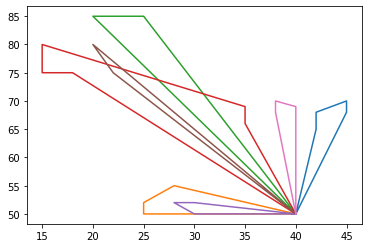

In [43]:
for x in routeToSubroute(best_individual, data):
    lst = []
    lst.append([data["depart"]['coordinates']['x'], data["depart"]['coordinates']['y']])
    for y in x:
        cust = "customer_" + str(y)
        lst.append([data[cust]['coordinates']['x'], data[cust]['coordinates']['y']])
    lst.append([data["depart"]['coordinates']['x'], data["depart"]['coordinates']['y']])
    arr = np.array(lst)
    plt.plot(arr[:,0],arr[:,1])
plt.show()